In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Point, Line, Segment, Ray, intersection
from typing import List
import itertools
from my_utils import * 
from line_walk import *

import warnings
warnings.filterwarnings('ignore')

# Структуры для представления триангуляции

## Мотивация

Выбор структуры для представления *триангуляции* оказывает существенное влияние на теоретическую трудоёмкость алгоритмов, а также на скорость конкретной реализации. Кроме того, выбор структуры может зависеть от цели дальнейшего использования триангуляции.

## Краткий ликбез

*Определение 1.* **Триангуляцией** называется планарный граф, все грани которого являются треугольниками.

*Определение 2.* Задачей **построения триангуляции** по заданному набору двумерных точек называется задача соединения заданных точек непересекающимися отрезками так, чтобы образовалась *триангуляция*. Заданный набор точек будем называть *точками триангуляции*.

*Определение 3.* *Триангуляция* называется **оптимальной**, если сумма длин всех рёбер минимальна среди всех возможных триангуляций, построенных на тех же *точках триангуляции*.

Для понимания того, как производятся оценки памяти структур, следует ознакомиться с [формулой Эйлера для планарных графов](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A4%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D0%B0_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0).

## Основные виды объектов триангуляции, операции с ними

В триангуляции выделяют 3 основных вида объектов: **узлы** (точки, вершины), **рёбра** (отрезки) и **треугольники**.

В большинстве алгоритмов построения триангуляции и алгоритмов её анализа требуются следующие операции с объектами триангуляции:

1. Треугольник → узлы: получение для данного треугольника координат образующих его узлов.
2. Треугольник → рёбра: получение для данного треугольника списка образующих его рёбер.
3. Треугольник → треугольники: получение для данного треугольника списка соседних с ним треугольников.
4. Ребро → узлы: получение для данного ребра координат образующих его узлов.
5. Ребро → треугольники: получение для данного ребра списка соседних с ним треугольников.
6. Узел → рёбра: получение для данного узла списка смежных рёбер.
7. Узел → треугольники: получение для данного узла списка смежных треугольников.

В зависимости от алгоритма некоторые операции могут быть не нужны. Например, в каких-то алгоритмах операции с рёбрами могут возникать не часто, поэтому рёбра могут представляться неявно, как одна из сторон некоторого треугольника. 

## Наиболее часто используемые структуры

### "Узлы с соседями"

В структуре «Узлы с соседями» для каждого узла триангуляции хранятся его координаты на плоскости и список указателей на соседние узлы (список номеров узлов), с которыми есть общие рёбра. По сути, список соседей определяет в неявном виде рёбра триангуляции. Треугольники же при этом не представляются вообще. 

Вся триангуляция будет представлена в виде одного словаря: *id узла -> узел*.

In [44]:
class NodeWithNeighbours(object):
    """
    Структура "Узел с соседями"
    
    :param idr:         уникальный идентификатор узла
    :param p:           объект класса Point (представляем координаты узла) 
    :param neigh_nodes: список смежных узлов (хранится id) 
    
    """
    def __init__(self, idr: int, p: Point, neigh_nodes: List[int]):
        self.idr = idr
        self.p = p
        self.neigh_nodes = neigh_nodes

**Оценка памяти**: заметим, что каждое ребро в нашей структуре (в данном случае, ребро представляет собой две соседних вершины) присутствует дважды (например, ребро, состоящее из вершин X и Y, сначала хранится у X, как сосед, а затем у Y, как сосед). Также в каждом узле хранится один int для id и два int'a для x и y (Point).

Получаем точную оценку: **2E + 3V**, где E - количество рёбер, V - количество вершин.

### "Узлы и треугольники"

В структуре «Узлы и треугольники» для каждого треугольника хранятся три указателя на образующие его узлы и три указателя на смежные треугольники, а каждый узел хранит указатели на инцидентные ему треугольники.

Нумерация узлов производится в порядке обхода против часовой стрелки. Напротив узла, который находится на i месте в списке образующих узлов, находится треугольник, лежащий на i месте в списке соседних треугольников (см. рисунок 1).

Вся триангуляция будет представлена в виде двух словарей: *id узла -> узел* и *id треугольника -> треугольник*.  

In [45]:
class NodesAndTriangles(object):
    """
    Структура "Узлы и треугольники"
    Представляет собой классы Node и Triangle
    
    """
    
    class Node(object):
        """
        Класс Узел
        
        :param idr:         уникальный идентификатор узла
        :param p:           объект класса Point (представляем координаты узла) 
        :param triangles:   инцидентные узлу треугольники (хранятся id)
        
        """
        def __init__(self, idr: int, p: Point, triangles: List[int]):
            self.idr = idr
            self.p = p
            self.triangles = triangles
        
    class Triangle(object):
        """
        Класс Треугольник
         
        :param idr:       уникальный идентификатор треугольника 
        :param nodes:     образующие треугольник узлы (хранятся id) 
        :param triangles: соседние треугольники (хранятся id) 
        
        """
        def __init__(self, idr: int, nodes: List[int], triangles: List[int]):
            self.idr = idr
            self.nodes = nodes
            self.triangles = triangles

![alt text](https://pp.userapi.com/c834300/v834300401/3a9cf/_pslElJKfbo.jpg "Узлы и треугольники")
Рисунок 1. Связи узлов и треугольников в структуре «Узлы и треугольники» 

**Оценка памяти**: произведем подсчет для узлов и треугольников отдельно:

Узлы займут **9V**, ибо один узел требует 9 int'ов: один int (id) + два int'a (Point) + 6 int'ов (среднее количество инцидентных узлу треугольников равно 6 (см. конспект про формулу Эйлера)).

Треугольники займут **7F**, ибо один треугольник требует 7 int'ов: один int (id) + 3 int'a (составляющие треугольник вершины) + 3 int'а (соседние треугольники).

Получаем верхнюю оценку: **9V + 7F**, где V - количество вершин, F - количество треугольников.

### "Узлы, рёбра и треугольники"

В структуре «Узлы, рёбра и треугольники» в явном виде задаются все объекты триангуляции: узлы, рёбра и треугольники. Для каждого ребра хранятся указатели на два концевых узла и два соседних треугольника. Для треугольников хранятся указатели на три образующих треугольник ребра. В каждом узле координаты и инцидентные треугольники. 

Вся триангуляция будет представлена в виде трёх словарей: *id узла -> узел*, *id ребра -> ребра* и *id треугольника -> треугольник*.  

In [47]:
class NodesAndEdgesAndTriangles(object):
    """
    Структура "Узлы, ребра и треугольники"
    
    Представляет собой классы Node, Edge и Triangle
    """
    
    class Node(object):
        """
        Класс Узел
         
        :param idr:        уникальный идентификатор узла
        :param p:          объект класса Point (представляем координаты узла)
        :param triangles:  инцидентные узлу треугольники (хранятся id)
        
        """
        def __init__(self, idr: int, p: Point, triangles: List[int]):
            self.idr = idr
            self.p = p
            self.triangles = triangles
            
    class Edge(object):
        """
        Класс Ребро
         
        :param idr:       уникальный идентификатор ребра 
        :param nodes:     список концевых узлов (хранятся id)
        :param triangles: соседние треугольники (хранятся id)
        
        """
        def __init__(self, idr: int, nodes: List[int], triangles: List[int]):
            self.idr = idr
            self.nodes = nodes
            self.triangles = triangles
            
    class Triangle(object):
        """
        Класс Треугольник
        
        :param idr:   уникальный идентификатор треугольника
        :param edges: образующие треугольник ребра (хранятся id)
        
        """
        def __init__(self, idr: int, edges: List[int]):
            self.idr = idr
            self.edges = edges

**Оценка памяти**: произведем подсчет для узлов, рёбер и треугольников отдельно:

Узлы займут **9V**, ибо один узел требует 9 int'ов: один int (id) + два int'a (Point) + 6 int'ов (среднее количество инцидентных узлу треугольников равно 6 (см. формулы Эйлера)).

Рёбра займут **5E**, ибо одно ребро требует 5 int'ов: один int (id) + два int'a (концы ребра) + два int'а (у одного ребра два инцидентных треугольника).

Треугольники займут **4F**, ибо один треугольник требует 4 int'а: один int (id) + 3 int'a (составляющие треугольник вершины).

Получаем верхнюю оценку: **9V + 5E + 4F**, где V - количество вершин, E - количество рёбер и F - количество треугольников.

### "Двойные рёбра"

В структуре «Двойные рёбра» основой триангуляции являются вершины, полурёбра и треугольники. Рассмотрим каждый элемент по отдельности:

* *Вершина* хранит в себе координаты узла и ссылку на любое инцидентное полуребро, выходящее из этого узла.

* *Полуребро* можно рассматривать, как ориентированное ребро. Хранит в себе ссылку на выходящий узел, ссылки на обратное, следующее и предыдущее ребра в порядке обхода треугольника, а также ссылку на инцидентный треугольник. 

* *Треугольник* хранит в себе любое полуребро, составляющее его границу.

In [49]:
class DoubleEdges(object):
    """
    Структура "Двойные ребра"
    
    Представляет собой классы Node, HalfEdge и Triangle
    """
    
    class Node(object):
        """
        Класс Узел
        
        :param idr:  уникальный идентификатор узла
        :param p:    объект класса Point (представляем координаты узла)
        :param he:   инцидентное полуребро, выходящее из p (хранится id)
        
        """
        def __init__(self, idr: int, p: Point, he: int):
            self.idr = idr
            self.p = p
            self.he = he
    
    class HalfEdge(object):
        """
        Класс Полуребро
        
        :param idr:      уникальный идентификатор полуребра 
        :param node:     выходящий узел (хранится id)
        :param prev:     предыдущее полуребро (хранится id)
        :param nxt:      следующее полуребро (хранится id)
        :param twin:     обратное полуребро (хранится id)
        :param triangle: инцидентный треугольник (хранится id)
        
        """
        def __init__(self, idr: int, node: int, prev: int, nxt: int, twin: int, triangle: int):
            self.idr = idr
            self.node = node
            self.prev = prev
            self.nxt = nxt
            self.twin = twin
            self.triangle = triangle
        
    class Triangle(object):
        """
        Класс Треугольник

        :param idr: уникальный идентификатор треугольника
        :param he:  полуребро, составляющее границу (хранится id) 

        """
        def __init__(self, idr: int, he: int):
            self.idr = idr
            self.he = he

![alt text](https://pp.userapi.com/c834302/v834302573/3dc06/H_C-Ul16tFU.jpg "Двойные рёбра")
Рисунок 2. Связи рёбер в структуре «Двойные рёбра» (стрелками обозначены полурёбра)

**Оценка памяти**: произведем подсчет для узлов, полурёбер и треугольников отдельно:

Узлы займут **4V**, ибо один узел требует 4 int'а: один int (id) + два int'a (Point) + 1 int (инцидентное полурёбро).

Полурёбра займут **12E**, ибо одно полуребро требует 6 int'ов: один int (id) + один int (выходящая вершина) + один int (треугольник) + 3 int'a (prev, next, twin полурёбра), а на каждое ребро есть два полуребра, отсюда х2.

Треугольники займут **2F**, ибо один треугольник требует 2 int'а: один int (id) + один int (любое инцидентное полуребро).

Получаем верхнюю оценку: **4V + 12E + 2F**, где V - количество вершин, E - количество рёбер и F - количество треугольников.

### "Лёгкие узлы и треугольники"

В структуре «Лёгкие узлы и треугольники» для каждого треугольника хранятся три указателя на образующие его узлы и три указателя на смежные треугольники, а каждый узел хранит только один указатель на инцидентный ему треугольник, что и является ключевым отличием от структуры "Узлы и треугольники".

Нумерация узлов производится в порядке обхода против часовой стрелки. Напротив узла, который находится на i месте в списке образующих узлов, находится треугольник, лежащий на i месте в списке соседних треугольников.

Вся триангуляция будет представлена в виде двух словарей: *id узла -> узел* и *id треугольника -> треугольник*. 

Такая структура используется в [CGAL](https://doc.cgal.org/latest/Triangulation_2/index.html).

In [48]:
class LightNodesAndTriangles(object):
    """
    Структура "Лёгкие узлы и треугольники"
    Представляет собой классы Node и Triangle
    
    """
    
    class Node(object):
        """
        Класс Узел
        
        :param idr:         уникальный идентификатор узла
        :param p:           объект класса Point (представляем координаты узла) 
        :param triangles:   любой инцидентный узлу треугольник (хранится  id)
        
        """
        def __init__(self, idr: int, p: Point, triangle: int):
            self.idr = idr
            self.p = p
            self.triangle = triangle
        
    class Triangle(object):
        """
        Класс Треугольник
         
        :param idr:       уникальный идентификатор треугольника 
        :param nodes:     образующие треугольник узлы (хранятся id) 
        :param triangles: соседние треугольники (хранятся id) 
        
        """
        def __init__(self, idr: int, nodes: List[int], triangles: List[int]):
            self.idr = idr
            self.nodes = nodes
            self.triangles = triangles

**Оценка памяти**: произведем подсчет для узлов и треугольников отдельно:

Узлы займут **4V**, ибо один узел требует 4 int'а: один int (id) + два int'a (Point) + один int (инцидентный треугольник).

Треугольники займут **7F**, ибо один треугольник требует 7 int'ов: один int (id) + 3 int'a (составляющие треугольник вершины) + 3 int'а (соседние треугольники).

Получаем верхнюю оценку: **4V + 7F**, где V - количество вершин, F - количество треугольников.

## Резюме и практические рекомендации

| Название структуры данных    | Узлы      | Рёбра     | Треугольники     | Оценка памяти     | Оценка памяти в V |
|:----------------------------:|:---------:|:---------:|:----------------:|:-----------------:|:-----------------:|
| "Узлы с соседями"            | **+**     |  **-**    |     **-**        | **3V + 2E**       | **9V**            |
| "Узлы и треугольники"        | **+**     |  **-**    |     **+**        | **9V + 7F**       | **23V**           | 
| "Узлы, рёбра и треугольники" | **+**     |  **+**    |     **+**        | **9V + 5E + 4F**  | **32V**           |
| "Двойные рёбра"              | **+**     |  **+**    |     **+**        | **4V + 12E + 2F** | **44V**           |
| "Лёгкие узлы и треугольники" | **+**     |  **-**    |     **+**        | **4V + 7F**       | **18V**           |

Таблица 1. Основные характеристики структур: «–» – элемент отсутствует, «+» – присутствует.

Выводы относительно рассмотренных структур:
* "Узлы с соседями" наименее удобная и используемая структура, так как не представляет в явном виде рёбра и треугольники.

* Удобной с точки зрения программирования является структура "Лёгкие узлы и треугольники".

* Для практического применения рекомендуются структуры "Двойные ребра" и "Лёгкие узлы и треугольники".

## Работа со структурами на примере задачи "Walking in triangulation" 

Рассмотрим как можно работать с описанными структурами. Решим следующую задачу:

Пусть дана трианугляция T, точка A, ребро E, которой точка A принадлежит, а также точка B.
Требуется найти все ребра заданной триангуляции T, пересекающиеся лучом AB.

Триангуляцию будем генерировать с помощью библиотеки *scipy* классом *Delaunay*. 

**Примечание**: подробное описание, как с этим работать, можно найти в соседнем конспекте "Краткое руководство по триангуляции Делоне в scipy" 

In [6]:
points = np.array([[0, 0], [5, 0], [10, 3], [0, 5], [5, 5], [5, 10], [3, 6], [1, -1], [7, -2], [2, 5]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

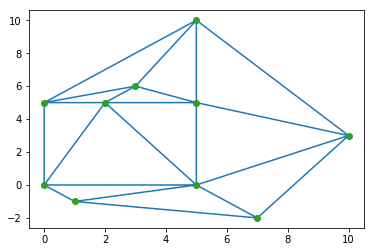

In [7]:
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:, 1], 'o')
plt.show()

Реализуем конверторы, преобразующие данную триангуляцию в описанные ранее структуры:

In [8]:
#Конвертер в NodeWithNeighbours
def scipy_tri_to_node_with_neighbours(tri):
    node_with_neighbours = dict()
    for index, p in enumerate(tri.points):
        b = tri.vertex_neighbor_vertices[0][index]
        e = tri.vertex_neighbor_vertices[0][index + 1]
        p_nodes = tri.vertex_neighbor_vertices[1][b : e]
        node_with_neighbours[index] = NodeWithNeighbours(index, Point(p[0], p[1]), p_nodes)
    return node_with_neighbours

In [9]:
#Конвертер в NodesAndTriangles
def scipy_tri_to_nodes_and_triangles(tri):
    nodes = dict()
    triangles = dict()
    for index_node, p in enumerate(tri.points):
        b = tri.vertex_neighbor_vertices[0][index_node]
        e = tri.vertex_neighbor_vertices[0][index_node + 1]
        p_nodes = tri.vertex_neighbor_vertices[1][b : e]
        p_triangles = []
        for i, j in itertools.combinations(p_nodes, r=2):
            s = set([i, j, index_node])
            for ind, k in enumerate(tri.simplices):
                if (s == set(k)):
                    p_triangles.append(ind)
                    break
        nodes[index_node] = NodesAndTriangles.Node(index_node, Point(p[0], p[1]), p_triangles)
    for index_triangles, t in enumerate(tri.simplices):
        triangles[index_triangles] = NodesAndTriangles.Triangle(index_triangles, t, tri.neighbors[index_triangles])
    return (nodes, triangles)

In [10]:
#Конвертер в NodesAndEdgesAndTriangles
def scipy_tri_to_nodes_and_edges_and_triangles(tri):
    nodes = dict()
    edges_to_idr = dict()
    idr_to_edges = dict()
    triangles = dict()
    for index_node, p in enumerate(tri.points):
        b = tri.vertex_neighbor_vertices[0][index_node]
        e = tri.vertex_neighbor_vertices[0][index_node + 1]
        p_nodes = tri.vertex_neighbor_vertices[1][b : e]
        p_triangles = []
        for i, j in itertools.combinations(p_nodes, r=2):
            s = set([i, j, index_node])
            for ind, k in enumerate(tri.simplices):
                if (s == set(k)):
                    p_triangles.append(ind)
                    break
        nodes[index_node] = NodesAndEdgesAndTriangles.Node(index_node, Point(p[0], p[1]), p_triangles)
    for index_triangles, t in enumerate(tri.simplices):
        for i, j in itertools.combinations(t, r=2):
            t_ij = (i, j)
            if (i > j):
                t_ij = (j, i)
            if (t_ij in edges_to_idr):
                continue
            s = len(edges_to_idr)
            bi = tri.vertex_neighbor_vertices[0][i]
            ei = tri.vertex_neighbor_vertices[0][i + 1]
            bj = tri.vertex_neighbor_vertices[0][j]
            ej = tri.vertex_neighbor_vertices[0][j + 1]
            inter_vs = set(tri.vertex_neighbor_vertices[1][bi : ei]) & set(tri.vertex_neighbor_vertices[1][bj : ej]) 
            n_triangles = []
            for v in inter_vs:
                for it, tt in enumerate(tri.simplices):
                    if (set(tt) == set([i, j, v])):
                        n_triangles.append(it)
                        break
            e = NodesAndEdgesAndTriangles.Edge(s, list(t_ij), n_triangles)
            edges_to_idr[t_ij] = s 
            idr_to_edges[s] = e
    for index_triangles, t in enumerate(tri.simplices):
        edges = []
        for i, j in itertools.combinations(t, r=2):
            t_ij = (i, j)
            if (i > j):
                t_ij = (j, i)
            edges.append(edges_to_idr[t_ij])
        triangles[index_triangles] = NodesAndEdgesAndTriangles.Triangle(index_triangles, edges)
    return [nodes, edges_to_idr, idr_to_edges, triangles]

In [29]:
#Конвертер в DoubleEdges
def scipy_tri_to_double_edges(tri):
    nodes = dict()
    half_edges = dict()
    triangles = dict()
    edges_to_idr_and_f = dict()
    count = 1
    for index_t, t in enumerate(tri.simplices):
        for i, j in itertools.combinations(t, r=2):
            t_ij = (i, j)
            if (i > j):
                t_ij = (j, i)
            if (t_ij in edges_to_idr_and_f):
                continue
            edges_to_idr_and_f[t_ij] = [count, 0]
            edges_to_idr_and_f[(t_ij[1], t_ij[0])] = [-count, 0]
            count = count + 1
    for index_t, t in enumerate(tri.simplices):
        le = [(t[0], t[1]), (t[1], t[2]), (t[2], t[0])]
        first = True
        for i, e in enumerate(le):
            idr = get_id(edges_to_idr_and_f, *e)
            edges_to_idr_and_f[e[0], e[1]][1] = 2
            if (edges_to_idr_and_f[e[1], e[0]][1] == 0):
                edges_to_idr_and_f[e[1], e[0]][1] = 1
            twin = -idr
            prev = get_id(edges_to_idr_and_f, *le[(i-1) % 3])
            nxt = get_id(edges_to_idr_and_f, *le[(i-1) % 3])
            he = DoubleEdges.HalfEdge(idr, e[0], prev, nxt, twin, index_t)
            half_edges[idr] = he
            if (first):
                first = False
                triangles[index_t] = DoubleEdges.Triangle(index_t, idr)
            if (e[0] in nodes):
                continue
            else:
                nodes[e[0]] = DoubleEdges.Node(e[0], tri.points[e[0]], idr)        
    for key, value in edges_to_idr_and_f.items():
        if (value[1] == 1):
            half_edges[-value[0]].twin = 0
    return [nodes, half_edges, triangles]
        
def get_id(edges_to_idr_and_f, v1, v2):
    return edges_to_idr_and_f[(v1, v2)][0]

In [35]:
#Конвертер в LightNodesAndTriangles
def scipy_tri_to_light_nodes_and_triangles(tri):
    nodes = dict()
    triangles = dict()
    for index_node, p in enumerate(tri.points):
        b = tri.vertex_neighbor_vertices[0][index_node]
        e = tri.vertex_neighbor_vertices[0][index_node + 1]
        p_nodes = tri.vertex_neighbor_vertices[1][b : e]
        triangle = None
        for i, j in itertools.combinations(p_nodes, r=2):
            flag = False
            s = set([i, j, index_node])
            for ind, k in enumerate(tri.simplices):
                if (s == set(k)):
                    triangle = ind
                    flag = True
                    break
            if (flag):
                break
        nodes[index_node] = LightNodesAndTriangles.Node(index_node, Point(p[0], p[1]), triangle)
    for index_triangles, t in enumerate(tri.simplices):
        triangles[index_triangles] = LightNodesAndTriangles.Triangle(index_triangles, t, tri.neighbors[index_triangles])
    return (nodes, triangles)

Теперь сконвертируем:

In [38]:
tri_node_with_neighbours = scipy_tri_to_node_with_neighbours(tri)
tri_nodes_and_triangles = scipy_tri_to_nodes_and_triangles(tri)
tri_nodes_and_edges_and_triangles = scipy_tri_to_nodes_and_edges_and_triangles(tri)
tri_double_edges = scipy_tri_to_double_edges(tri)
tri_light_nodes_and_triangles = scipy_tri_to_light_nodes_and_triangles(tri)

Реализованные алгоритмы "Walking in triangulation" для каждой из структур можно найти в *line_walk.py*, однако читателю предлагается написать алгоритм для структуры "Лёгкие узлы и треугольники" самостоятельно:

In [50]:
""" 
Стартовая функция, из которой должно произойти решение о том, дана нам точка на ребре или же это узел триангуляции.
Если первое, то вызвать line_walk_light_nodes_and_triangles_e и добавить данное ребро в edges, если второе, то
вызвать line_walk_light_nodes_and_triangles_v.
"""
def line_walk_light_nodes_and_triangles(tri_light_nodes_and_triangles, a, v1, v2, b, edges):
    pass

""" 
Рассмотреть три случая:
1) пересечение луча по одному из ребер:
добавить это ребро и вызвать line_walk_light_nodes_and_triangles_v
2) пересечение луча с одним из смежных ребер:
добавить это ребро и вызвать line_walk_light_nodes_and_triangles_e
3) пересечение луча с двумя смежными ребрами (произошло пересечение по вершине):
вызвать line_walk_light_nodes_and_triangles_v
"""
def line_walk_light_nodes_and_triangles_e(tri_light_nodes_and_triangles, v1, v2, ray, b, edges):
    pass

""" 
Рассмотреть два случая:
1) пересечение луча по одному из инцидентных ребер триангуляции:
добавить это ребро и вызвать line_walk_light_nodes_and_triangles_v
2) пересечение луча с одним из противоположных ребер в инцидентных треугольниках:
добавить это ребро и вызвать line_walk_light_nodes_and_triangles_e
"""
def line_walk_light_nodes_and_triangles_v(tri_light_nodes_and_triangles, v, ray, b, edges):
    pass

Попробуем их на практике. Для этого сначала напишем функцию test_line_walk(), которая будет генерировать нам точки A, B и ребро E с концами v1 и v2, на котором лежит A.

In [14]:
def test_line_walk(tri):
    v1_idr = np.random.randint(0, len(tri.points)) 
    s = tri.vertex_neighbor_vertices[0][v1_idr]
    e = tri.vertex_neighbor_vertices[0][v1_idr + 1]
    rv = np.random.randint(s, e)
    v2_idr = tri.vertex_neighbor_vertices[1][rv]
    is_v = np.random.randint(-1, 1)
    v1 = Point(tri.points[v1_idr][0], tri.points[v1_idr][1])
    v2 = Point(tri.points[v2_idr][0], tri.points[v2_idr][1])
    a = None
    if (is_v > 0):
        if (is_v > 0.5):
            a = Point(tri.points[v1_idr][0], tri.points[v1_idr][1])
        else:
            a = Point(tri.points[v2_idr][0], tri.points[v2_idr][1])
    else:
        a = Point((tri.points[v1_idr][0] + tri.points[v2_idr][0])/2, (tri.points[v1_idr][1] + tri.points[v2_idr][1])/2)
    b = None
    
    while True:
        b_x = np.random.randint(-10, 10)
        b_y = np.random.randint(-10, 10)
        b = Point(b_x, b_y)
        if (not a.equals(b)):
            break
    
    return [a, v1, v2, b]

А тепер запустим и убедимся, что вне зависимости от выбранной структуры, мы пришли к одному ответу.

**Внимание!** Для тех, кто написал алгоритм для структуры "Лёгкие узлы и треугольники" предлагается раскомментировать строки с answers4, чтобы проверить на корректность написанную реализацию.

In [41]:
#test = [Point(7, -2), Point(7, -2), Point(10, 3), Point(5, 0)]
#test = [Point(17/2, 1/2), Point(7, -2), Point(10, 3), Point(-7, 9)]
#test = [Point(6, -1), Point(5, 0), Point(7, -2), Point(1, 4)]
#test = [Point(0, 5/2), Point(0, 5), Point(0, 0), Point(0, 1)]
#test = [Point(1, 5), Point(0, 5), Point(2, 5), Point(-4, 5)]
#test = [Point(5/2, 11/2), Point(3, 6), Point(2, 5), Point(-10, -7)]

for i in range(150):
    test = test_line_walk(tri)
    answers1 = line_walk_node_with_neighbours(tri_node_with_neighbours, *test, [])   
    answers2 = line_walk_nodes_and_triangles(tri_nodes_and_triangles, *test, [])
    answers3 = line_walk_nodes_and_edges_and_triangles(tri_nodes_and_edges_and_triangles, *test, [])
    #answers4 = line_walk_light_nodes_and_triangles(tri_light_nodes_and_triangles, *test, [])
    if (answers1 == answers2 == answers3): #== answers4):
        continue
    else:
        print("Mistake!")
        print("Test:")
        print(test)
        print("Right answer:")
        print(answers1)
        #print("Your answer:")
        #print(answers4)
        break

Теперь выведем нашу триангуляцию вместе с лучом и найденными ребрами на каком-нибудь тесте.  

В данной визуализации, луч выделен черным цветом, ребра, которые пересеклись с лучом, отмечены красным, а все остальные ребра синим:

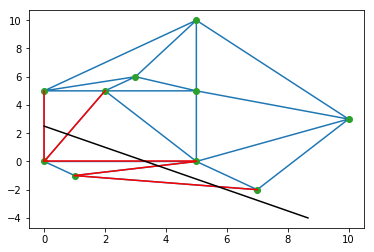

In [40]:
test = test_line_walk(tri)
answers1 = line_walk_node_with_neighbours(tri_node_with_neighbours, *test, [])

_, ray = inf_ray(test[0], test[3], 9) #генерируем луч для визуализации
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:, 1], 'o')
for seg in answers1:
    pt1, pt2 = seg.points
    plt.plot((pt1.x, pt2.x), (pt1.y, pt2.y), "red")
pt1, pt2 = ray.points
plt.plot((pt1.x, pt2.x), (pt1.y, pt2.y), "black")
plt.show()